In [4]:
# @title 1. Setup & Load
!pip install -q diffusers transformers accelerate safetensors openai pydantic rembg onnxruntime-gpu

import torch
import gc
import os
import getpass
import numpy as np
from diffusers import AutoPipelineForImage2Image
from PIL import Image
from IPython.display import display
from rembg import remove, new_session

if 'pipe' in globals(): del pipe
gc.collect()
torch.cuda.empty_cache()

print("⏳ Loading SDXL-Turbo...")
pipe = AutoPipelineForImage2Image.from_pretrained(
    "stabilityai/sdxl-turbo",
    torch_dtype=torch.float16,
    variant="fp16",
    low_cpu_mem_usage=True
).to("cuda")

pipe.enable_vae_slicing()
pipe.enable_vae_tiling()

print("⏳ Loading Background Remover...")
rembg_session = new_session("u2net")

print("✅ System Ready.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.8 MB/s eta 0:00:00
⏳ Loading SDXL-Turbo...


model_index.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


⏳ Loading Background Remover...


100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 237GB/s]


✅ System Ready.


In [5]:
# @title 2. Generator (Generative Fade)

def generate_dream_scene(prompt_a, prompt_b=None, type="pano", frames=4):
    torch.cuda.empty_cache()

    # --- STYLE CONSTANTS ---
    # We add "unfinished" and "negative space" to the core style
    style_ink = "Ink and watercolor, thick india ink lines, rough sketch, "
    style_env = "vintage paper texture, hazy, unfinished edges, negative space. "
    neg_base = "photorealistic, 3d render, modern, text, blur, border, frame, solid fill"

    def build_full_prompt(raw_text, is_pano):
        # Defensive Check
        if raw_text is None: raw_text = "void"

        safe_text = " ".join(raw_text.split()[:25])

        if is_pano:
            # --- PANO TRICK: "Horizontal Band" ---
            # We ask for the detail to be in the center, fading out at top/bottom.
            return (
                style_ink + style_env + safe_text +
                ", ultra wide angle, 14mm lens, vast scale, distant horizon, "
                ", 360 equirectangular panorama, "
                "empty scene, devoid of subjects, fading to white at top and bottom, horizontal composition"
            )
        else:
            return (
                style_ink + safe_text +
                ", isolated cutout on white background, cel shaded, flat lighting, dynamic pose"
            )

    # --- CONFIG ---
    if type == "pano":
        width, height = 1024, 512
        neg = neg_base + ", people, animals, creatures, objects, items,  focal point, claustrophobic, close up,"
    else:
        width, height = 384, 384

        neg = neg_base + ", background, ground, shadow, tree, gradient, square, wall, floor, static, multiple, two, many, duo, group, twins, clones, split view"

    generated_images = []

    # Force Fresh Canvas
    current_image = Image.new("RGB", (width, height), (255, 255, 255))

    print(f"🖌️ Generating {frames} frames for ({type})...")

    # --- LOOP ---
    for i in range(frames):

        target_prompt = prompt_b if prompt_b else prompt_a

        # 1. LOGIC SELECTOR
        if type == "pano":
            current_raw = prompt_a
            strength = 1.0 if i == 0 else 0.4

        else: # SPRITES
            if i == 0:
                current_raw = prompt_a
                strength = 1.0
            elif i == 1:
                current_raw = prompt_a
                strength = 0.5
            elif i == 2:
                current_raw = target_prompt
                strength = 0.7
            else:
                current_raw = target_prompt
                strength = 0.55

        full_prompt = build_full_prompt(current_raw, type == "pano")

        # 2. GENERATE
        image = pipe(
            prompt=full_prompt,
            negative_prompt=neg,
            image=current_image,
            num_inference_steps=4,
            strength=strength,
            guidance_scale=0.0,
            width=width,
            height=height
        ).images[0]

        # 3. POST-PROCESS (Sprites Only)
        if type == "sprite":
            clean_img = remove(image, session=rembg_session)
            final_img = Image.new("RGB", clean_img.size, (255, 255, 255))
            final_img.paste(clean_img, (0, 0), clean_img)
            image = final_img

        generated_images.append(image)
        current_image = image

    return generated_images

In [6]:
# @title 3. The Dream Scryer (RPG Options Mode)
from typing import List
from pydantic import BaseModel, Field
from openai import OpenAI
import os, getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key: ")
client = OpenAI()

# --- SYSTEM PROMPT ---
SYSTEM_PROMPT = """
You are the Dream Scryer, trained in Central Image analysis by Hartmann. Map the dream to a Single Hex with 7 Stations, which are places where represent major dream images.

### 1. THE STAGE (Background)
- Describe the **CONTAINER** (Environment) ONLY, which is the setting of the central image as if it were a theatre backdrop.

### 2. THE ACTORS (Entities)
- **Station 0 (Center):** The Central Image (Concrete Noun).
- **Stations 1-6:** Important characters or objects. Only if explicitly in text.
    - Populate these with important entities from the text.
    - If the dream only has one subject, Stations 1-6 MUST be NULL.
    - *Example:* "Red balloon in empty room" -> Station 0="Balloon", Stations 1-6=NULL.


### 3. INTERACTION OPTIONS (NEW)
- For every entity, provide **5 Distinct Interaction Options** for the player.
- Vary the tone: [Aggressive, Friendly, Inquisitive, Physical, Surreal].
- Examples: "Ask why they are sad", "Poke it with a stick", "Offer a gift".
- Short text (Max 6 words).

### OUTPUT
Return strictly structured JSON.
"""

# --- INTERACTION PROMPT ---
INTERACTION_PROMPT = """
You are the Dungeon Master. Calculate the entity's REACTION.
1. Output new animation prompts (Active Verbs).
2. Provide **5 NEW Interaction Options** based on the new emotional state.
"""

class Station(BaseModel):
    id: str = Field(..., description="ID")
    position_index: int = Field(..., description="0=Center")
    entity_name: str | None = Field(..., description="Name of Actor.")
    state_start: str | None = Field(..., description="Start: [Concrete Noun] + [Active Verb].")
    state_end: str | None = Field(..., description="End: [Concrete Noun] + [Active Verb].")
    entity_greeting: str | None = Field(..., description="Greeting.")

    # --- NEW: BUTTONS ---
    interaction_options: List[str] = Field(..., description="List of 5 short interaction options (Strings).", min_items=5, max_items=5)

class DreamHex(BaseModel):
    title: str
    description_360: str = Field(..., description="Global setting. EMPTY. Max 15 words.")
    central_imagery: str = Field(..., description="Hartmann Analysis.")
    stations: List[Station]

class DreamGenerationResponse(BaseModel):
    hex: DreamHex
    summary: str

class InteractionResponse(BaseModel):
    new_state_start: str
    new_state_end: str
    new_greeting: str
    # --- NEW: UPDATED BUTTONS ---
    new_options: List[str] = Field(..., description="5 New options based on reaction.", min_items=5, max_items=5)

def analyze_dream(dream_text):
    print(f"🔮 Scrying dream: '{dream_text[:30]}...'")
    try:
        completion = client.beta.chat.completions.parse(
            model="gpt-4o-mini",
            messages=[{"role": "system", "content": SYSTEM_PROMPT}, {"role": "user", "content": dream_text}],
            response_format=DreamGenerationResponse,
        )
        return completion.choices[0].message.parsed
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

def analyze_interaction(entity_name, current_state, user_command):
    print(f"🧠 Calculating reaction for {entity_name}...")
    try:
        query = f"Entity: {entity_name} ({current_state}). User Action: {user_command}"
        completion = client.beta.chat.completions.parse(
            model="gpt-4o-mini",
            messages=[{"role": "system", "content": INTERACTION_PROMPT}, {"role": "user", "content": query}],
            response_format=InteractionResponse,
        )
        return completion.choices[0].message.parsed
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

/tmp/ipython-input-4156652570.py:52: PydanticDeprecatedSince20: `min_items` is deprecated and will be removed, use `min_length` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  interaction_options: List[str] = Field(..., description="List of 5 short interaction options (Strings).", min_items=5, max_items=5)
/tmp/ipython-input-4156652570.py:52: PydanticDeprecatedSince20: `max_items` is deprecated and will be removed, use `max_length` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  interaction_options: List[str] = Field(..., description="List of 5 short interaction options (Strings).", min_items=5, max_items=5)
/tmp/ipython-input-4156652570.py:69: PydanticDeprecatedSince20: `min_items` is deprecated and will be removed, use `min_length` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydant

🔮 Scrying dream: 'Yes, all the time.  The last o...'

✨ Dream Title: Hide and Seek in the Mountains

✨ Dream Hex: title='Hide and Seek in the Mountains' description_360='Mountainous terrain, shadows of camouflage sheets.' central_imagery='Couple hiding behind camouflage sheets, gunfire in the distance.' stations=[Station(id='0', position_index=0, entity_name='Camo Sheets', state_start='Camo Sheets Concealing', state_end='Camo Sheets Flapping', entity_greeting='The sheets rustle in the wind.', interaction_options=['Tug at the sheets', 'Hide further behind', 'Inspect the sheets closely', 'Shout for your husband', 'Mimic the sound of gunfire']), Station(id='1', position_index=1, entity_name='Husband', state_start='Husband Worrying', state_end='Husband Stressed', entity_greeting='He looks concerned about the situation.', interaction_options=['Comfort him gently', "Ask why he's worried", 'Suggest moving to safety', 'Joke about the ammo', 'Push him playfully']), Station(id='2', position_inde

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

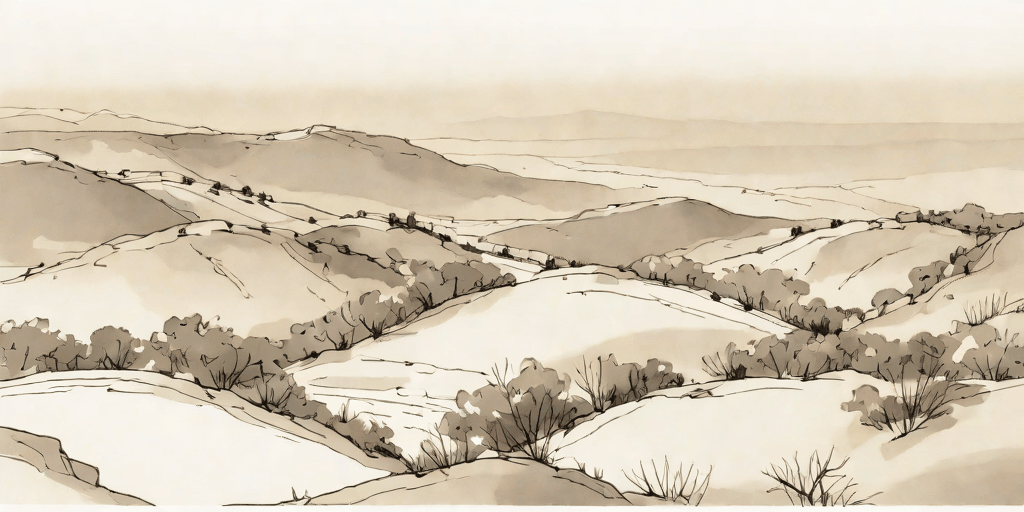


--- ENTITIES (4 Frames) ---

📍 STATION 0: Camo Sheets
   Action: Camo Sheets Concealing -> Camo Sheets Flapping
   all station: id='0' position_index=0 entity_name='Camo Sheets' state_start='Camo Sheets Concealing' state_end='Camo Sheets Flapping' entity_greeting='The sheets rustle in the wind.' interaction_options=['Tug at the sheets', 'Hide further behind', 'Inspect the sheets closely', 'Shout for your husband', 'Mimic the sound of gunfire'] 
🖌️ Generating 4 frames for (sprite)...


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

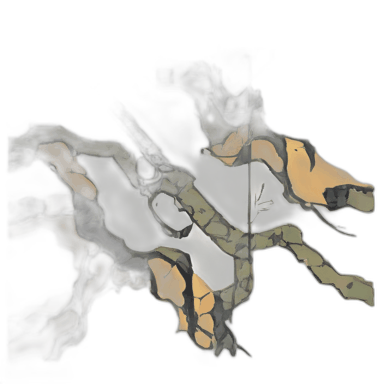


📍 STATION 1: Husband
   Action: Husband Worrying -> Husband Stressed
   all station: id='1' position_index=1 entity_name='Husband' state_start='Husband Worrying' state_end='Husband Stressed' entity_greeting='He looks concerned about the situation.' interaction_options=['Comfort him gently', "Ask why he's worried", 'Suggest moving to safety', 'Joke about the ammo', 'Push him playfully'] 
🖌️ Generating 4 frames for (sprite)...


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

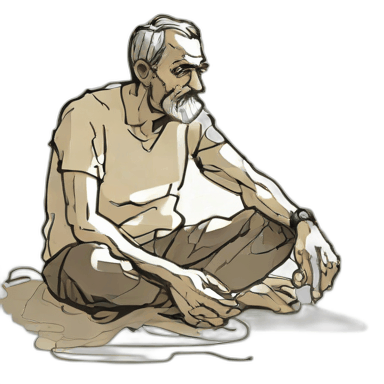


📍 STATION 2: Bullets
   Action: Bullets Whizzing -> Bullets Crashing
   all station: id='2' position_index=2 entity_name='Bullets' state_start='Bullets Whizzing' state_end='Bullets Crashing' entity_greeting='They zip past with a sharp crack.' interaction_options=['Count the bullets', 'Duck and cover', 'Analyze their trajectory', 'Pretend to catch one', 'Laugh at the chaos'] 
🖌️ Generating 4 frames for (sprite)...


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

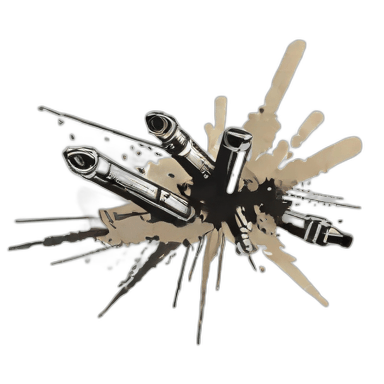

In [7]:
# @title 4. Run DreamHex & Interact
from IPython.display import display, Image as IPImage
import time

def create_gif(image_list, filename="entity_anim.gif"):
    image_list[0].save(
        filename, save_all=True, append_images=image_list[1:],
        optimize=False, duration=150, loop=0
    )
    return filename

current_hex_state = None

def materialize_hex(user_report):
    global current_hex_state
    dream_data = analyze_dream(user_report)
    if not dream_data: return
    current_hex_state = dream_data

    print(f"\n✨ Dream Title: {dream_data.hex.title}")
    print(f"\n✨ Dream Hex: {dream_data.hex}")

    # BACKGROUND
    print(f"\n--- BACKGROUND (3 Frames) ---")
    print(dream_data.hex.description_360)
    pano_frames = generate_dream_scene(dream_data.hex.description_360, type="pano", frames=3)
    pano_gif = create_gif(pano_frames, "background.gif")
    display(IPImage(filename=pano_gif))

    # ENTITIES
    print("\n--- ENTITIES (4 Frames) ---")
    sorted_stations = sorted(dream_data.hex.stations, key=lambda x: x.position_index)

    for station in sorted_stations:
        # Strict check: If name is None, skip.
        if not station.entity_name: continue
        if not station.state_start: continue

        print(f"\n📍 STATION {station.position_index}: {station.entity_name}")
        print(f"   Action: {station.state_start} -> {station.state_end}")
        print(f"   all station: {station} ")

        frame_list = generate_dream_scene(
            prompt_a=station.state_start,
            prompt_b=station.state_end,
            type="sprite",
            frames=4
        )

        gif_filename = f"station_{station.position_index}.gif"
        create_gif(frame_list, gif_filename)
        display(IPImage(filename=gif_filename))

def interact(station_index, user_command):
    global current_hex_state
    if not current_hex_state:
        print("❌ No dream active.")
        return

    station = next((s for s in current_hex_state.hex.stations if s.position_index == station_index), None)
    if not station or not station.entity_name:
        print(f"❌ No entity at station {station_index}")
        return

    print(f"\n👊 INTERACTION: You -> {station.entity_name}: \"{user_command}\"")

    reaction = analyze_interaction(station.entity_name, station.state_end, user_command)

    print(f"   Reaction: {reaction.new_state_start} -> {reaction.new_state_end}")

    frame_list = generate_dream_scene(
        prompt_a=reaction.new_state_start,
        prompt_b=reaction.new_state_end,
        type="sprite",
        frames=4
    )

    gif_filename = f"reaction_{station_index}.gif"
    create_gif(frame_list, gif_filename)
    display(IPImage(filename=gif_filename))

    station.state_start = reaction.new_state_start
    station.state_end = reaction.new_state_end

# --- TEST ---
# "Empty white room" is the stress test.
# It should produce the balloon (Center) and maybe nothing else,
# OR hallucinate a relevant object (Mirror/Door), but NEVER a "Wall".
materialize_hex("Yes, all the time.  The last one was I was in the mountains with my husband, and we were trying to hide behind some kind of camo-ish sheets and people were shooting up towards us and my husband wasn't happy that they were using .40 cal ammo. . .but I wasn't too concerned because I knew it was just a dream.  I think it means that my husband talks about guns way too much. . ")

In [ ]:
# @title 6. Export to React Native (Zip)
import json
import shutil
from google.colab import files

# 1. Run the generation once to populate variables
print("Generating fresh dream for export...")
materialize_hex("I saw a giant stone golem sleeping in a cave.")

if current_hex_state:
    # Create folder structure
    os.makedirs("export/assets", exist_ok=True)

    # 1. Save JSON
    # We convert Pydantic to Dict
    data = current_hex_state.model_dump()

    # We need to map the image filenames to the JSON so RN can find them
    # (In a real app, these would be S3 URLs)
    data['hex']['background_image'] = "background.gif"

    for station in data['hex']['stations']:
        if station['entity_name']:
            station['sprite_image'] = f"station_{station['position_index']}.gif"

    with open("export/dream_data.json", "w") as f:
        json.dump(data, f, indent=2)

    # 2. Move Images
    # (Assuming the gifs were saved in the current directory by previous cells)
    if os.path.exists("background.gif"):
        shutil.copy("background.gif", "export/assets/background.gif")

    for station in data['hex']['stations']:
        fname = f"station_{station['position_index']}.gif"
        if os.path.exists(fname):
            shutil.copy(fname, f"export/assets/{fname}")

    # 3. Zip it
    shutil.make_archive("dreamhex_assets", 'zip', "export")
    files.download("dreamhex_assets.zip")
    print("✅ Download complete! Unzip this into your React Native project.")